In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from torch import nn
from torch.utils.data import DataLoader, RandomSampler
from tqdm.notebook import tqdm

from models.energy_models import EnergyAttentionRNN, EnergyAttentionRNN2D, EnergyRNN
from models.probability_models import ProbabilityRNN, ProbabilityAttentionRNN
from data_utils.pytorch_datasets import EnergyDataset, EnergyDataset2D, ProbabilityDataset

## Datasets

In [2]:
train_data_path = './data/train_data_32k.hdf5'
batch_size = 128
n_random_samples = 3200

energy_dataset_2D = EnergyDataset2D(filepath=train_data_path)
random_sampler_2D = RandomSampler(energy_dataset_2D, num_samples=n_random_samples, replacement=True)
energy_loader_2D = DataLoader(
    energy_dataset_2D,
    batch_size=batch_size,
    sampler=random_sampler_2D,
    num_workers=0)

## Energy Models

In [3]:
energy_gru_ckpt = './model_weights/energy/rnn/GRU_1L/model.ckpt'
energy_lstm_ckpt = './model_weights/energy/rnn/LSTM_1L/model.ckpt'
energy_attn_ckpt = './model_weights/energy/rnn_attn/GRU_1L_1H/model.ckpt'
energy_2D_attn_ckpt = './model_weights/energy/rnn_attn/2D_GRU_1L_1H/model.ckpt'

energy_gru = EnergyRNN.load_from_checkpoint(energy_gru_ckpt)
energy_gru.eval()

energy_lstm = EnergyRNN.load_from_checkpoint(energy_lstm_ckpt)
energy_lstm.eval()

energy_attn = EnergyAttentionRNN.load_from_checkpoint(energy_attn_ckpt)
energy_attn.eval()

energy_2D_attn = EnergyAttentionRNN2D.load_from_checkpoint(energy_2D_attn_ckpt)
energy_2D_attn.eval()

EnergyAttentionRNN2D(
  (rnn): GRU(1, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=1, bias=True)
  (attention_rows): MultiheadAttention(
    (out_proj): Linear(in_features=512, out_features=512, bias=True)
  )
  (attention_cols): MultiheadAttention(
    (out_proj): Linear(in_features=512, out_features=512, bias=True)
  )
)

## Probability Models

In [4]:
prob_gru_ckpt = './model_weights/probability/rnn/GRU_1L/model.ckpt'
prob_lstm_ckpt = './model_weights/probability/rnn/LSTM_1L/model.ckpt'
prob_attn_ckpt = './model_weights/probability/rnn_attn/GRU_1L_1H/model.ckpt'

prob_gru = ProbabilityRNN.load_from_checkpoint(prob_gru_ckpt)
prob_gru.eval()

prob_lstm = ProbabilityRNN.load_from_checkpoint(prob_lstm_ckpt)
prob_lstm.eval()

prob_attn = ProbabilityAttentionRNN.load_from_checkpoint(prob_attn_ckpt)
prob_attn.eval()

ProbabilityAttentionRNN(
  (rnn): GRU(1, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=1, bias=True)
  (attention): MultiheadAttention(
    (out_proj): Linear(in_features=512, out_features=512, bias=True)
  )
)

In [5]:
preds = defaultdict(list)
true_energy = []
with torch.no_grad():
    for x_row, x_col, y in tqdm(energy_loader_2D):
        y_pred, _ = energy_2D_attn(x_row, x_col)
        preds['energy_2D'].append(y_pred)
        y_pred, _ = energy_attn(x_row)
        preds['energy_attn'].append(y_pred)
        y_pred = energy_lstm(x_row)
        preds['energy_lstm'].append(y_pred)
        y_pred = energy_gru(x_row)
        preds['energy_gru'].append(y_pred)
        
        y_pred = prob_attn.predict_energy(x_row)
        preds['prob_attn'].append(y_pred)
        y_pred = prob_lstm.predict_energy(x_row)
        preds['prob_lstm'].append(y_pred)
        y_pred = prob_gru.predict_energy(x_row)
        preds['prob_gru'].append(y_pred)
        
        true_energy.append(y)

In [6]:
def center_predictions(preds_list):
    preds_tensor = torch.cat(preds_list, axis=0)
    return (preds_tensor - torch.mean(preds_tensor)).squeeze()

In [7]:
centered_preds = {}
for model, model_preds in tqdm(preds.items()):
    centered_preds[model] = center_predictions(model_preds)
    
true_centered = center_predictions(true_energy)

In [8]:
criterion = nn.MSELoss()
for model, model_preds in tqdm(centered_preds.items()):
    rmse = torch.sqrt(criterion(true_centered, model_preds))
    print(f"RMSE for {model}: {rmse}")

RMSE for energy_2D: 5.2982378005981445
RMSE for energy_attn: 7.689065933227539
RMSE for energy_lstm: 8.551366806030273
RMSE for energy_gru: 9.297406196594238
RMSE for prob_attn: 12.815935134887695
RMSE for prob_lstm: 11.152807235717773
RMSE for prob_gru: 11.293487548828125



In [15]:
def plot_difference(true_centered, model_centered_preds, ax, label, delta=False):

    diffs = model_centered_preds - true_centered
    buckets = defaultdict(list)
    for true, pred in zip(true_centered, diffs):
        buckets[true].append(pred)

    n_buckets = len(buckets)
    y_high = np.zeros(n_buckets)
    y_center = np.zeros(n_buckets)
    y_low = np.zeros(n_buckets)
    x_vals = np.zeros(n_buckets)
    for i, key in enumerate(sorted(buckets.keys())):
        x_vals[i] = key
        diffs_arr = np.array(buckets[key])
        mean = np.mean(diffs_arr)
        std = np.std(diffs_arr)
        y_low[i] = mean - std
        y_center[i] = mean
        y_high[i] = mean + std
        
    if delta:
        ax.fill_between(x_vals, y_high, y_low, alpha=0.2)
    ax.plot(x_vals, y_center, label=label)

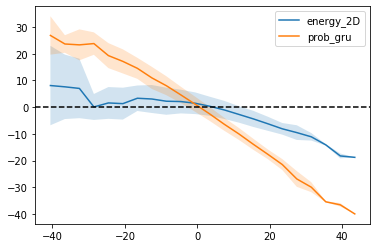

In [18]:
ax = plt.axes()
selected_models = ['energy_2D', 'prob_gru']
delta = True
for model, model_preds in tqdm(centered_preds.items()):
    if model in selected_models:
        plot_difference(true_centered.numpy(), model_preds.numpy(), ax, model, delta)
        
ax.legend()
ax.axhline(0, linestyle='--', c='black')